# Cognition & Computation - Lab 2

In [106]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import tqdm
from DBN import DBN
import torch.nn.functional as functional

## Data

In [11]:
def get_data():
    mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

    mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))
    mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
    mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

    return mnist_train, mnist_test


In [13]:
mnist_train, mnist_test = get_data()

data_train = mnist_train.data
targets_train = mnist_train.targets

data_test = mnist_test.data
targets_test = mnist_test.targets


In [14]:
class DBNParams:
    visible_units=28*28
    hidden_units=[500]
    k=1
    learning_rate=0.1
    learning_rate_decay=False
    initial_momentum=0.5
    final_momentum=0.9
    weight_decay=0.0002
    xavier_init=False
    increase_to_cd_k=False
    use_gpu=True

class TrainParameters:
    epochs = 40  # 50
    batch_size = 125  # 100
    class_num = 10

## Model prepare & train

In [16]:
dbn_mnist = DBN(
    visible_units = DBNParams.visible_units,
    hidden_units = DBNParams.hidden_units,
    k = DBNParams.k,
    learning_rate = DBNParams.learning_rate,
    learning_rate_decay = DBNParams.learning_rate_decay,
    initial_momentum = DBNParams.initial_momentum,
    final_momentum = DBNParams.final_momentum,
    weight_decay = DBNParams.weight_decay,
    xavier_init = DBNParams.xavier_init,
    increase_to_cd_k = DBNParams.increase_to_cd_k,
    use_gpu = DBNParams.use_gpu
)


In [17]:
dbn_mnist.train_static(
    data_train,
    targets_train,
    TrainParameters.epochs,
    TrainParameters.batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2253   |0.0614   |320.5723 |13.2572   |
|20    |1.1661   |0.0586   |304.4309 |12.0162   |
|30    |1.1484   |0.0571   |297.6883 |11.9260   |
|40    |1.1377   |0.0561   |293.3468 |11.0602   |


In [20]:
def move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()
    
move_parameters_to_cpu(dbn_mnist)

## Linear readouts

Let's first compute the hidden representations:

In [52]:
def get_kth_layer_repr(input, dbn_model, n_layer):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_model.rbm_layers[n_layer].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [53]:
hidden_repr_layer_1 = get_kth_layer_repr(
    input = data_train,
    dbn_model = dbn_mnist,
    n_layer = 0
)

In [54]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)

  def forward(self, x):
    return self.linear(x)

### First hidden layer representations

Let's train the readout layer:

In [55]:
def _train(model, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input).squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [56]:
def attach_perceptron(dbn_model, n_layer, class_num):
    rbm_layer_size = dbn_model.rbm_layers[n_layer].W.shape[1]
    return Perceptron(rbm_layer_size, class_num = class_num)

perceptron_hidden_0 = attach_perceptron(
    dbn_model = dbn_mnist,
    n_layer = 0,
    class_num = 10
)
_train(
    model = perceptron_hidden_0, 
    input = hidden_repr_layer_1, 
    targets = targets_train, 
    epochs = 1500
)

epoch 0/1500, loss = 2.307758
epoch 100/1500, loss = 0.655293
epoch 200/1500, loss = 0.494940
epoch 300/1500, loss = 0.430149
epoch 400/1500, loss = 0.393106
epoch 500/1500, loss = 0.368321
epoch 600/1500, loss = 0.350172
epoch 700/1500, loss = 0.336081
epoch 800/1500, loss = 0.324684
epoch 900/1500, loss = 0.315185
epoch 1000/1500, loss = 0.307083
epoch 1100/1500, loss = 0.300045
epoch 1200/1500, loss = 0.293843
epoch 1300/1500, loss = 0.288310
epoch 1400/1500, loss = 0.283325


Let's test it on the hold-out dataset:

In [57]:
hidden_repr_layer_1_test = get_kth_layer_repr(
    input = data_test, 
    dbn_model = dbn_mnist,
    n_layer = 0
)

In [58]:
predictions_first_hidden = perceptron_hidden_0(hidden_repr_layer_1_test)

In [59]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [60]:
_compute_accuracy(predictions_first_hidden, targets_test)

0.9279000163078308

## Comparison with a feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [84]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, first_hidden_layer_size, output_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, output_size)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [85]:
ffnn = Feedforward(
    input_size = 784,
    first_hidden_layer_size = 500,
    output_size = 10
)

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [86]:
_train(
    ffnn, 
    data_train,
    targets = targets_train, 
    epochs=120
)

epoch 0/120, loss = 2.302258
epoch 10/120, loss = 2.184969
epoch 20/120, loss = 2.057674
epoch 30/120, loss = 1.908835
epoch 40/120, loss = 1.740265
epoch 50/120, loss = 1.562953
epoch 60/120, loss = 1.392292
epoch 70/120, loss = 1.240542
epoch 80/120, loss = 1.112804
epoch 90/120, loss = 1.008243
epoch 100/120, loss = 0.923349
epoch 110/120, loss = 0.854191


In [87]:
predictions_ffnn = ffnn(data_test)

In [89]:
_compute_accuracy(predictions_ffnn, targets_test)

0.8467000126838684

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [90]:
def _inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

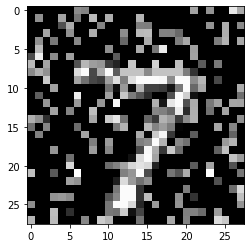

In [91]:
noise_level = 0.3
mnist_test_with_noise = _inject_noise(data_test, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [92]:
def _get_accuracy_values_at_noise_level(
  data,
  targets,
  noise_level,
  dbn_model,
  n_layer,  # representation
  perceptron_model,
  ffnn_model
  ):

  noisy_data = _inject_noise(data, noise_level)
  
  hidden_repr_noisy = get_kth_layer_repr(input = noisy_data, dbn_model = dbn_model, n_layer = n_layer)

  predictions_perceptron = perceptron_model(hidden_repr_noisy)  

  predictions_ffnn = ffnn_model(noisy_data) #.reshape((noisy_data.shape[0], 784)))
  
  accuracy_perceptron = _compute_accuracy(predictions_perceptron, targets)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn, targets)
  
  return accuracy_perceptron, accuracy_ffnn

In [93]:
_get_accuracy_values_at_noise_level(
    data = data_test,
    targets = targets_test,
    noise_level = 0.2,
    dbn_model = dbn_mnist,
    n_layer = 0,
    perceptron_model = perceptron_hidden_0,
    ffnn_model = ffnn
)

(0.8862000107765198, 0.8187999725341797)

Let's now get an overview of the robustness of the representations to different levels of noise:

In [94]:
def plot_noise_robustness_curves(
  noise_levels,
  data,
  targets,
  dbn_model,
  n_layer,
  perceptron_model,
  ffnn_model
  ):
  accuracies_perceptron = []
  accuracies_ffnn = []
  
  for noise_level in noise_levels:
    accuracy_perceptron, accuracy_ffnn = _get_accuracy_values_at_noise_level(
      data = data,
      targets = targets,
      noise_level = noise_level,
      dbn_model = dbn_model,
      n_layer = n_layer,
      perceptron_model = perceptron_model,
      ffnn_model = ffnn_model
  
    )
    accuracies_perceptron.append(accuracy_perceptron)
    accuracies_ffnn.append(accuracy_ffnn)
  
  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracies_perceptron)
  ax.plot(range(len(noise_levels)), accuracies_ffnn)
  
  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

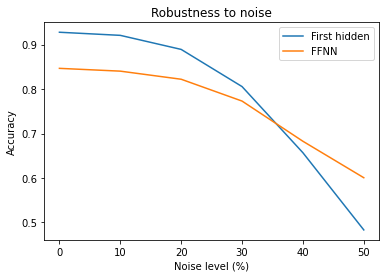

In [95]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5] #, 0.6, 0.7, 0.8]

plot_noise_robustness_curves(
    noise_levels = noise_levels,
    data = data_test,
    targets = targets_test,
    dbn_model = dbn_mnist, 
    n_layer = 0,
    perceptron_model = perceptron_hidden_0,
    ffnn_model = ffnn
)

# Adversarial attacks

In [96]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [97]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_mnist = dbn_mnist

    def forward(self, image):
        x, __ = self.dbn_mnist.forward(image)
        x = self.readout.forward(x)
        return x

In [98]:
dbn_with_readout = DBNWithReadOut(
    dbn_mnist, 
    perceptron = perceptron_hidden_0
)

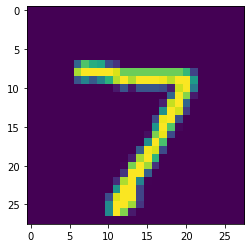

In [101]:
idx = 1
test_image = data_test[:idx].reshape(1, 28, 28)
__ = plt.imshow(test_image.reshape(28,28))

In [102]:
attacked_model = ffnn

test_label = targets_test[:idx]

test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {prediction}.")

loss_value = torch.nn.functional.cross_entropy(model_outputs, test_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is 7.


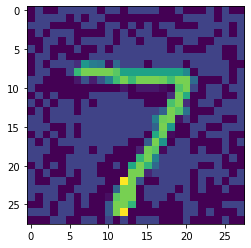

In [103]:
perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [104]:
model_outputs = attacked_model(perturbed_image)
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 9.


## Robustness to adversarial attacks

In [107]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial predi ction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [108]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('data/', train=False, download=False, transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

In [109]:
device = torch.device("cpu")

In [110]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 10000/10000 [00:18<00:00, 532.85it/s]


Epsilon: 0.1	Test Accuracy = 5415 / 10000 = 0.5415



In [112]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

100%|██████████| 10000/10000 [00:12<00:00, 811.47it/s]


Epsilon: 0.1	Test Accuracy = 6583 / 10000 = 0.6583



  0%|          | 0/10000 [00:00<?, ?it/s]


Here's the original sample:



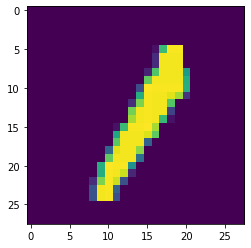


Here's a perturbed sample:



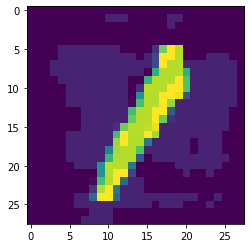


Here's what a 1-steps reconstructed sample looks like:



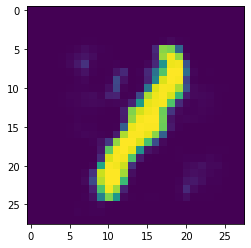

100%|██████████| 10000/10000 [00:16<00:00, 621.37it/s]


Epsilon: 0.1	Test Accuracy = 7659 / 10000 = 0.7659



In [113]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

## Effect of $\epsilon$

In [114]:
def test_epsilon_values_effect(epsilons, model, device, loader, n_steps):
  accuracies = list()

  for eps in epsilons:
      acc = test_robustness_to_attack(model, device, loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [115]:
epsilons = [0, .05, .1, .15, .2, .25]
accuracies_ffnn = test_epsilon_values_effect(epsilons, ffnn, device, test_loader, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps=0)
accuracies_rbm_1 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 1)
accuracies_rbm_2 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 2)

100%|██████████| 10000/10000 [00:22<00:00, 442.26it/s]


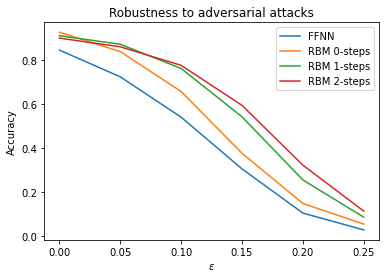

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilons, accuracies_ffnn)
__ = ax.plot(epsilons, accuracies_rbm_0)
__ = ax.plot(epsilons, accuracies_rbm_1)
__ = ax.plot(epsilons, accuracies_rbm_2)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)